# Tutorial: distribution space coupling in *high-dimensional* trajectory space

In this tutorial we will show how to solve distribution coupling with high-dimensional trajectories using the `distnav` package.

## Install/Import dependencies

Please install the following dependencies:
 - distnav (available via `pip install distnav`)
 - NumPy
 - Jax
 - SciPy
 - Matplotlib
 - George (for Gaussian processes regression, available via `pip install george`)

In [1]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
from jax.scipy.stats import multivariate_normal as jmvn
import matplotlib.pyplot as plt
import george
from george import kernels

## Computing agent initial preferences with Gaussian processes

We first need compute initial preference for agent with simulated start points and navigation destinations.

In [2]:
# start points for four pedestrians
ped_starts = np.array([
    [0.25, 0.15],
    [1.85, 0.25],
    [1.75, 1.85],
    [0.15, 1.75]
])
# destinations for four pedestrians
ped_dests = np.array([
    [1.8, 1.8],
    [0.2, 1.8],
    [0.2, 0.2],
    [1.8, 0.2]
])

Then, based on these information, we use Gaussian processes (GPs) regression to compute the *initial preference distribution* for each pedestrian over their future trajectories. We start by specifying the Gaussian processes kernels, in this tutorial we use a single Matern kernel, but you can combine different kernels for more complicated scenarios.

In [3]:
ped_kernels = [
    kernels.Matern52Kernel(250) * 5e-02
    for _ in range(4)
] # we use same kernels for all four pedestrians

We will also need a mean function to description a general motion model, here we use a constant velocity model (this step is not necessary, but could reduce the amount of tuning needed for kernels).

In [4]:
class mean_func():
    def __init__(self, v0, vT, T):
        self.v0 = v0
        self.vT = vT
        self.T = float(T)
    def get_value(self, t):
        return self.v0 + (self.vT-self.v0) * (t/self.T)

Lastly, we need to add the start points and destinations as "training data" for GPs to do regression.

In [5]:
training_x = np.array([
    [ped_starts[i][0], ped_dests[i][0]] for i in range(4)
]) # training data for x positions of four pedestrians
training_y = np.array([
    [ped_starts[i][1], ped_dests[i][1]] for i in range(4)
]) # training data for y positions of four pedestrians

T = 39 # trajectory time steps of prediction
training_idx = np.array([0, T+1]) # index for the training data, here we only have the first time step (t=0) and last time step/destination (t=T)
training_err = np.array([1e-03, 1e-03]) # uncertainty over the training data, here it represents agent's preference at the start point and destination
predict_idx = np.arange(T) + 1 # time step indices to be predicted, here they are the intermediate time steps between 0 and T

Now we can define the GPs.

In [6]:
ped_gp_x = [
    george.GP(kernel=ped_kernels[i], mean=mean_func(v0=ped_starts[i][0], vT=ped_dests[i][0], T=T), fit_white_noise=True)
    for i in range(4)
]
ped_gp_y = [
    george.GP(kernel=ped_kernels[i], mean=mean_func(v0=ped_starts[i][1], vT=ped_dests[i][1], T=T), fit_white_noise=True)
    for i in range(4)
] # we do 1D regression for x and y positions separately

Now it's time for GP regression, the outputs would a mean vector and covariance matrix representing a Gaussian distribution over the predicted trajectories (x and y positions separately) for each pedestrian.

In [7]:
# initialize GPs
for i in range(4):
    ped_gp_x[i].compute(training_idx, training_err)
    ped_gp_y[i].compute(training_idx, training_err)

In [8]:
# GP regression
gp_mean_x = []
gp_cov_x = []
gp_mean_y = []
gp_cov_y = []
for i in range(4):
    mean_x, cov_x = ped_gp_x[i].predict(training_x[i], predict_idx, 
                                        return_cov=True)
    gp_mean_x.append(mean_x.copy())
    gp_cov_x.append(cov_x.copy())
    
    mean_y, cov_y = ped_gp_y[i].predict(training_y[i], predict_idx, 
                                        return_cov=True)
    gp_mean_y.append(mean_y.copy())
    gp_cov_y.append(cov_y.copy())

## DistNav optimization over high-dimension trajectories

After we compute the initial preferences with GPs, we can use DistNav optimization to compute the optimal preference distributions. Since the computing analytical solution is intractable with high-dimension trajectories, we use samples to approximate the subproblem solution through Monte-Carlo integration.

We start by generating samples from the initial preference distributions and compute the initial preference for each sample.

In [9]:
num_samples = 500
ped_samples_x = np.zeros((num_samples * 4, T)) # we stack samples from all pedestrians into a 2D array
ped_samples_y = np.zeros((num_samples * 4, T))
for i in range(4):
    ped_samples_x[num_samples*i : num_samples*(i+1)] = mvn.rvs(mean=gp_mean_x[i],
                                                               cov=gp_cov_x[i], 
                                                               size=num_samples)
    ped_samples_y[num_samples*i : num_samples*(i+1)] = mvn.rvs(mean=gp_mean_y[i],
                                                               cov=gp_cov_y[i], 
                                                               size=num_samples)
    # one trick in practice is to replace one sample with the GP mean
    ped_samples_x[num_samples*i] = gp_mean_x[i].copy()
    ped_samples_y[num_samples*i] = gp_mean_y[i].copy()

Let's plot the samples to see what they look like :)

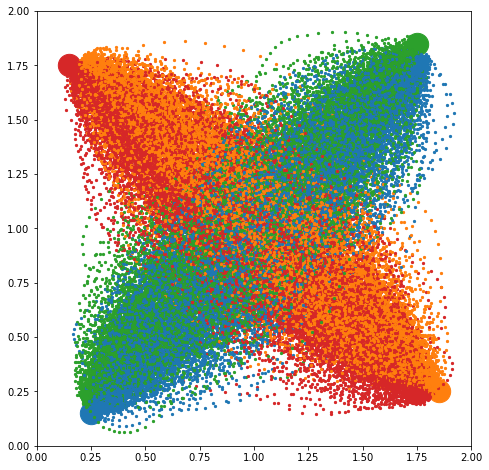

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8.,8,))
ax.set_xlim(0., 2.)
ax.set_ylim(0., 2.)
ax.set_aspect('equal')

for i in range(4): # plot start point
    ax.scatter(ped_starts[i][0], ped_starts[i][1], marker='o',
               s=500, color='C'+str(i)) 
    
for i in range(num_samples): # plot samples
    for j in range(4):
        ax.scatter(ped_samples_x[j*num_samples + i],
                   ped_samples_y[j*num_samples + i],
                   s=5, color='C'+str(j))

Don't forget to compute the initial preference for each sample. Here we compute the log instead of the original value to avoid overflow.

In [11]:
origin_logpdf_x = np.zeros((4, num_samples))
origin_logpdf_y = np.zeros((4, num_samples))

for i in range(4):
    origin_logpdf_x[i] = jmvn.logpdf(ped_samples_x[i*num_samples : (i+1)*num_samples],
                               gp_mean_x[i], gp_cov_x[i])
    origin_logpdf_y[i] = jmvn.logpdf(ped_samples_y[i*num_samples : (i+1)*num_samples],
                               gp_mean_y[i], gp_cov_y[i])

origin_logpdf = origin_logpdf_x * origin_logpdf_y

We can re-plot the samples, and set the transparency based on the sample's original preference (normalize it between 0 and 1).

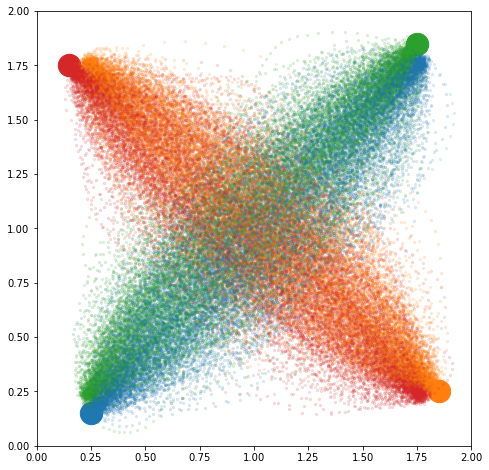

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8.,8,))
ax.set_xlim(0., 2.)
ax.set_ylim(0., 2.)
ax.set_aspect('equal')

for i in range(4): # plot start point
    ax.scatter(ped_starts[i][0], ped_starts[i][1], marker='o',
               s=500, color='C'+str(i)) 

for i in range(num_samples): # plot samples
    for j in range(4):
        alpha = 1.0 - np.exp(-1e-05 * (origin_logpdf[j][i] - 20000))
        ax.scatter(ped_samples_x[j*num_samples + i],
                   ped_samples_y[j*num_samples + i],
                   s=5, color='C'+str(j), alpha=alpha)

Now, let's define an interact model for the trajectories. Here we need to define an function to evaluate collision likelihood between two trajectories, the inputs for this method are shown in the example below. Note that this function is user-specified, you can try your own function depending on the problem. And in the example below we use `numba` to accelerate the implementation.

In [13]:
from numba import jit

@jit(nopython=True, cache=True)
def collision_likelihood(traj1_x, traj1_y, traj2_x, traj2_y, predict_len):
    ll = np.zeros(predict_len)
    
    for t in range(predict_len):
        dist = (traj1_x[t]-traj2_x[t])**2 + (traj1_y[t]-traj2_y[t])**2
        if dist < 0.03:
            ll[t] = 10.0
        else:
            ll[t] = 0.0
    
    return ll.max()

Finally, we can the `distnav` package to do the computation and find the optimal preference for each agent. You can install the package via `pip install distnav`.

In [14]:
# !pip3 install distnav
import distnav

In [15]:
nav = distnav.distnav(collision_likelihood, ped_samples_x, ped_samples_y,
                      origin_logpdf, T, 4, num_samples)

After defining the `distnav` obeject, the first thing is to do some preparation for the optimization. This is the most time-consuming step, but could lots of time when optimization starts.

In [16]:
nav.prepare()

preparation finished.


When the pre-optimization preparation is finished, we can start the optimization to update the weight for each sample.

In [17]:
opt_weights, opt_weights_log = nav.optimize(thred=1e-9, max_iter=50, return_log=True)

optimization terminated at iteration [27] with objective: 9.551714355905726e-10


After we have the (log) optimal weights for samples, we can approximate the optimal preference value for each sample. 

In [18]:
opt_preferences_log = opt_weights_log + origin_logpdf
opt_preferences_log = np.clip(opt_preferences_log, a_min=0.0, a_max=None)

After the optimization converges, we can get the updated weights, and re-plot the samples to see the optimal preferences for each agent.

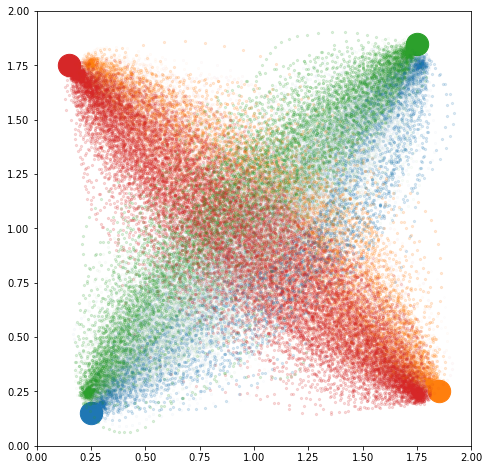

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8.,8,))
ax.set_xlim(0., 2.)
ax.set_ylim(0., 2.)
ax.set_aspect('equal')

for i in range(4): # plot start point
    ax.scatter(ped_starts[i][0], ped_starts[i][1], marker='o',
               s=500, color='C'+str(i)) 
    
for i in range(num_samples): # plot samples
    for j in range(4):
        alpha = 1.0 - np.exp(-5e-06 * opt_preferences_log[j][i])
        ax.scatter(ped_samples_x[j*num_samples + i],
                   ped_samples_y[j*num_samples + i],
                   s=5, color='C'+str(j), alpha=alpha)

Furthermore, we can plot the original sample distribution with the optimal one for better comparison.

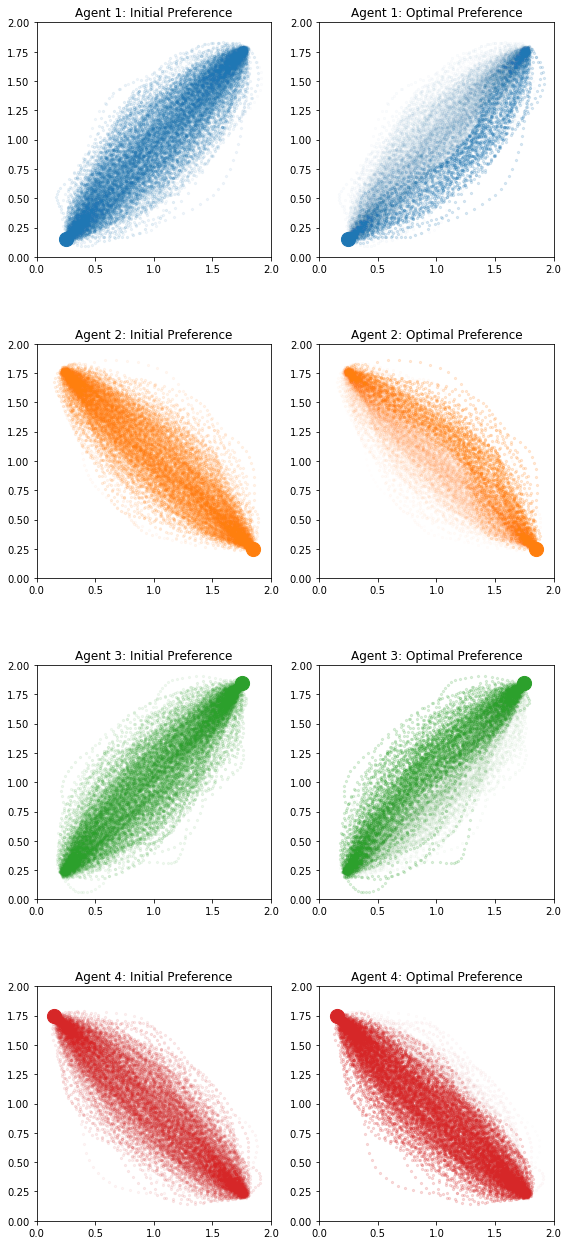

In [20]:
fig, ax = plt.subplots(4, 2, figsize=(8.,18,), tight_layout=True)

for i in range(4): # plot start point
    ax[i,0].set_xlim(0., 2.)
    ax[i,0].set_ylim(0., 2.)
    ax[i,0].set_aspect('equal')
    ax[i,0].scatter(ped_starts[i][0], ped_starts[i][1], marker='o',
               s=200, color='C'+str(i)) 
    ax[i,0].set_title('Agent {}: Initial Preference'.format(i+1))
    
    ax[i,1].set_xlim(0., 2.)
    ax[i,1].set_ylim(0., 2.)
    ax[i,1].set_aspect('equal')
    ax[i,1].scatter(ped_starts[i][0], ped_starts[i][1], marker='o',
               s=200, color='C'+str(i)) 
    ax[i,1].set_title('Agent {}: Optimal Preference'.format(i+1))
    
    for j in range(num_samples):
        alpha = 1.0 - np.exp(-2e-05 * (origin_logpdf[i][j] - origin_logpdf.min()))
        ax[i,0].scatter(ped_samples_x[i*num_samples + j],
                        ped_samples_y[i*num_samples + j],
                        s=5, color='C'+str(i), alpha=alpha)
        
        alpha = 1.0 - np.exp(-5e-06 * opt_preferences_log[i][j])
        ax[i,1].scatter(ped_samples_x[i*num_samples + j],
                   ped_samples_y[i*num_samples + j],
                   s=5, color='C'+str(i), alpha=alpha)

The decisoin-making process in DistNav *doesn't* rely on prediction of specific trajectories for each agent, but we can still find the "optimal trajectory" for each agent by finding the sample with largest approximated optimal preference value.

In [21]:
opt_traj_x = np.array([
    ped_samples_x[i*num_samples + np.argmax(opt_preferences_log[i])]
    for i in range(4)
])
opt_traj_y = np.array([
    ped_samples_y[i*num_samples + np.argmax(opt_preferences_log[i])]
    for i in range(4)
])

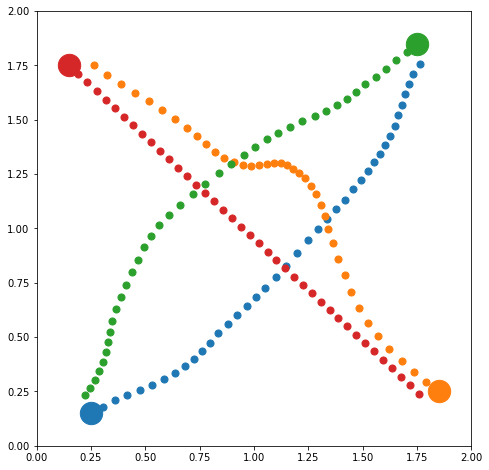

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8.,8,))
ax.set_xlim(0., 2.)
ax.set_ylim(0., 2.)
ax.set_aspect('equal')

for i in range(4): # plot start point
    ax.scatter(ped_starts[i][0], ped_starts[i][1], marker='o',
               s=500, color='C'+str(i)) 
    ax.scatter(opt_traj_x[i], opt_traj_y[i], marker='o',
               s=50, color='C'+str(i)) 